In [1]:
from math import pi

from scipy.signal import butter, filtfilt
import numpy as np
import talib

import matplotlib.pyplot as plt

from openbb_terminal.sdk import openbb

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://docs.openbb.co/sdk/quickstart/installation/

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://docs.openbb.co/sdk/quickstart/installation/

In [8]:
# Use OpenBB to download the EUR/USD price and get the returns.
data = openbb.forex.load(
    from_symbol="EUR",
    to_symbol="USD",
    start_date="2016-01-01",
    end_date="2021-12-31"
)

prices = (
    data["Adj Close"]
    .to_frame()
    .rename(
        columns={
            "Adj Close": "close"
        }
    )
)

prices["log_return"] = (
    prices.close
    .apply(np.log)
    .diff(1)
)
prices

,close,log_return
date,,
2016-01-01,1.085906,NaN
2016-01-04,1.085399,-0.000467
2016-01-05,1.082755,-0.002439
2016-01-06,1.075199,-0.007003
2016-01-07,1.077900,0.002508
...,...,...
2021-12-24,1.132734,-0.000136
2021-12-27,1.132426,-0.000272
2021-12-28,1.133003,0.000510


In [9]:
# Build the cycle model and filter
# Hilbert Transform - Dominant Cycle Phase
prices["phase"] = talib.HT_DCPHASE(prices.close)

# Convert into a wave using a cycle model
prices["signal"] = np.sin(prices.phase + pi / 4)

# Use the Hilbert Transform - Dominant Cycle Period
prices["period"] = talib.HT_DCPERIOD(prices.close)

prices

,close,log_return,phase,signal,period
date,,,,,
2016-01-01,1.085906,NaN,NaN,NaN,NaN
2016-01-04,1.085399,-0.000467,NaN,NaN,NaN
2016-01-05,1.082755,-0.002439,NaN,NaN,NaN
2016-01-06,1.075199,-0.007003,NaN,NaN,NaN
2016-01-07,1.077900,0.002508,NaN,NaN,NaN
...,...,...,...,...,...
2021-12-24,1.132734,-0.000136,263.743424,0.593209,23.210316
2021-12-27,1.132426,-0.000272,277.779433,0.860838,22.763816
2021-12-28,1.133003,0.000510,6.952943,0.993321,22.259135


In [4]:
# Create bandpass filter
def butter_bandpass(data, period, delta=0.5, fs=5):
    nyq = 0.5 * fs

    # Low cutoff frequency
    low = 1.0 / (period * (1 + delta))
    low /= nyq

    # High cutoff frequency
    high = 1.0 / (period * (1 - delta))
    high /= nyq

    b, a = butter(2, [low, high], btype="band")

    return filtfilt(b, a, data)

def roll_apply(e):
    close = prices.close.loc[e.index]
    period = prices.period.loc[e.index][-1]
    out = butter_bandpass(close, period)
    return out[-1]

In [10]:
# Apply the filter
prices["filtered"] = (
    prices.dropna()
    .rolling(window=30)
    .apply(lambda series: roll_apply(series), raw=False)
    .iloc[:, 0]
)

prices["amplitude"] = (
    prices.
    filtered
    .rolling(window=30)
    .apply(
        lambda series: series.max() - series.min()
    )
)

prices["ema_amplitude"] = (
    talib
    .EMA(
        prices.amplitude,
        timeperiod=30
    )
)
prices

,close,log_return,phase,signal,period,filtered,amplitude,ema_amplitude
date,,,,,,,,
2016-01-01,1.085906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,1.085399,-0.000467,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,1.082755,-0.002439,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,1.075199,-0.007003,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,1.077900,0.002508,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-12-24,1.132734,-0.000136,263.743424,0.593209,23.210316,-0.001656,0.005170,0.004520
2021-12-27,1.132426,-0.000272,277.779433,0.860838,22.763816,-0.001041,0.005170,0.004562
2021-12-28,1.133003,0.000510,6.952943,0.993321,22.259135,-0.000704,0.005170,0.004602


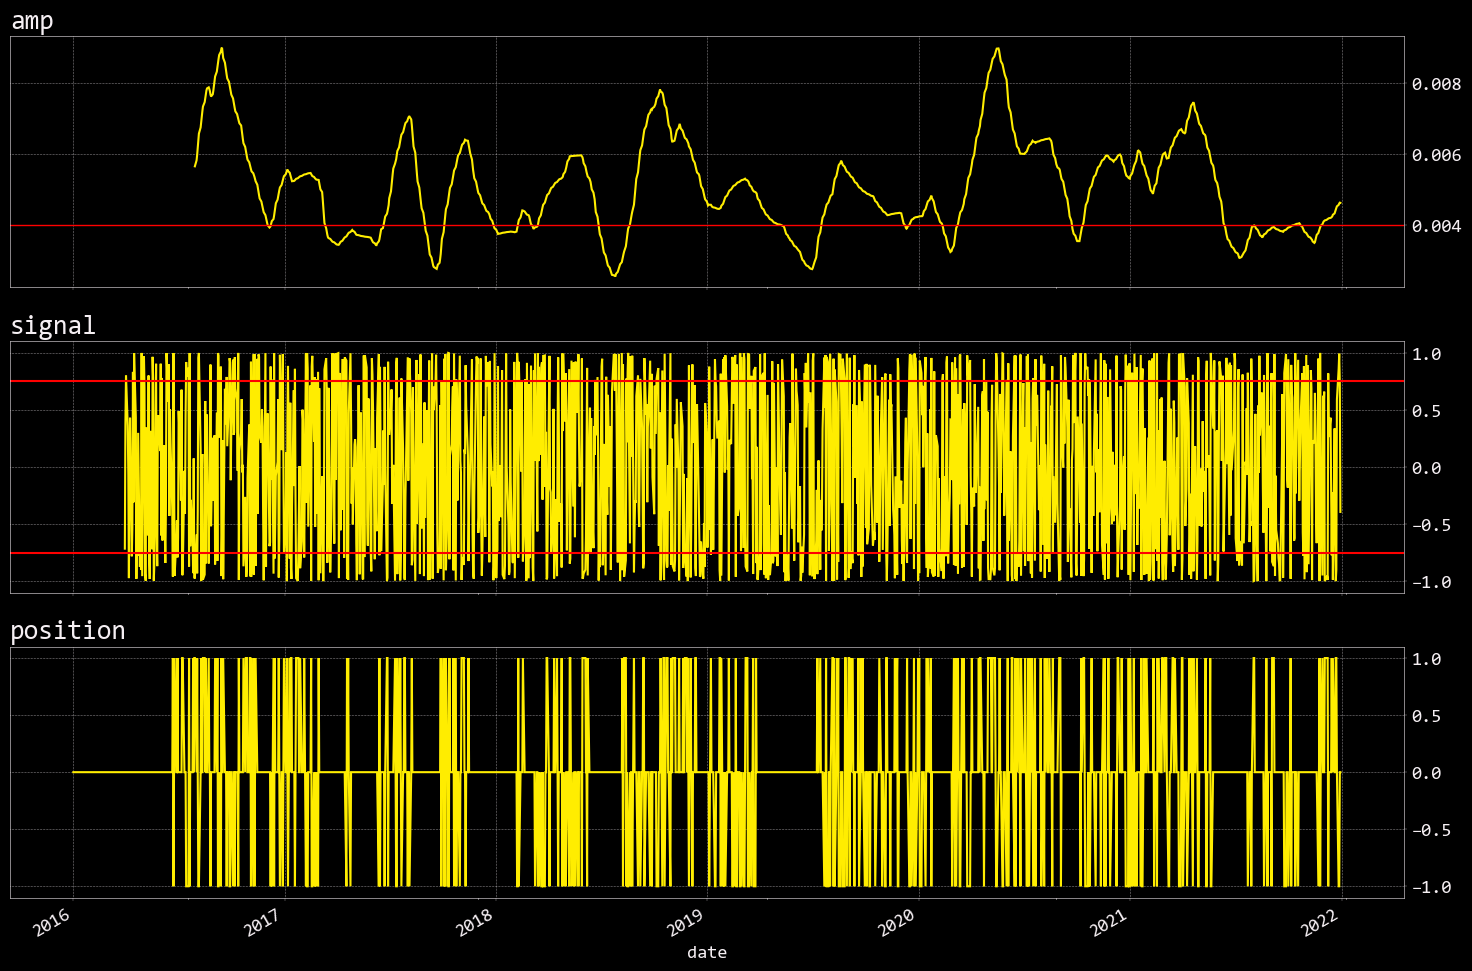

In [12]:
# Plot the results
signal_thresh = 0.75
amp_thresh = 0.004  # 40 pips

prices["position"] = 0
prices.loc[
    (prices.signal >= signal_thresh) &
    (prices.amplitude > amp_thresh), "position"
] = -1
prices.loc[
    (prices.signal <= -signal_thresh) &
    (prices.amplitude > amp_thresh), "position"
] = 1

fig, axes = plt.subplots(
    nrows=3,
    figsize=(15, 10),
    sharex=True
)

prices.ema_amplitude.plot(
    ax=axes[0],
    title="amp"
)
axes[0].axhline(
    amp_thresh,
    lw=1,
    c="r"
)
prices.signal.plot(
    ax=axes[1],
    title="signal"
)
axes[1].axhline(
    signal_thresh,
    c="r"
)
axes[1].axhline(
    -signal_thresh,
    c="r"
)
prices.position.plot(
    ax=axes[2],
    title="position"
)
fig.tight_layout()

In [13]:
prices

,close,log_return,phase,signal,period,filtered,amplitude,ema_amplitude,position
date,,,,,,,,,
2016-01-01,1.085906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-01-04,1.085399,-0.000467,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-01-05,1.082755,-0.002439,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-01-06,1.075199,-0.007003,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-01-07,1.077900,0.002508,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
2021-12-24,1.132734,-0.000136,263.743424,0.593209,23.210316,-0.001656,0.005170,0.004520,0
2021-12-27,1.132426,-0.000272,277.779433,0.860838,22.763816,-0.001041,0.005170,0.004562,-1
2021-12-28,1.133003,0.000510,6.952943,0.993321,22.259135,-0.000704,0.005170,0.004602,-1
